# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [66]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import skimage.io

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [67]:
class ViolinConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "violin"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512 #changed
    IMAGE_MAX_DIM = 512 # changed

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 80 ## changed

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 189/IMAGES_PER_GPU

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 30
    
config = ViolinConfig()
config.display()

import warnings
import re

warnings.filterwarnings('ignore', category=FutureWarning, message=re.escape("Input image dtype is bool. Interpolation is not defined with bool data type."))



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [68]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [69]:
class ViolinDataset(utils.Dataset):
    def load_violins(self, dataset_dir, json_path):
        # Ajouter la classe
        self.add_class("violin", 1, "violin")  # 1 est l'ID de la classe "violon"

        # Charger les annotations depuis le fichier JSON
        with open(json_path) as f:
            annotations = json.load(f)
        #print(annotations)
        # Parcourir les annotations pour ajouter les images
        for annotation in annotations:
            #filename = annotation['filename']
            filename = annotations[annotation]['filename']
            #width = annotations[annotation]['width']
            #height = annotations[annotation]['height']
            size = annotations[annotation]['size']
            polygons = annotations[annotation]['regions']  # Cela peut être des masques ou des boîtes englobantes

            image_path = os.path.join(dataset_dir, filename)
            self.add_image(
                "violin",
                image_id=filename,
                path=image_path,
                size=size,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """
        Charge les masques de segmentation pour une image donnée.
        Chaque objet est représenté par un polygone (polyline).
        """
        # Obtenir les informations de l'image à partir de image_id
        info = self.image_info[image_id]
        
        # Charger l'image pour obtenir sa taille
        image = self.load_image(image_id)
        height, width = image.shape[:2]
        
        # Initialiser un masque vide de taille (hauteur, largeur, nombre de polygones)
        mask = np.zeros((height, width, len(info['polygons'])), dtype=np.uint8)
        # Liste des ID de classes pour les objets
        class_ids = []
        # Parcourir les régions annotées (polygones)
        for i, region in enumerate(info['polygons']):
            
            # Extraire les coordonnées du polygone
            shape_attr = region['shape_attributes']
            all_points_x = shape_attr['all_points_x']
            all_points_y = shape_attr['all_points_y']
            # Convertir les coordonnées du polygone en indices de pixels
            poly_x, poly_y = skimage.draw.polygon(all_points_y, all_points_x)
            
            # Assurer que les indices sont dans les limites de l'image
            poly_x = np.clip(poly_x, 0, height - 1)
            poly_y = np.clip(poly_y, 0, width - 1)
            # Remplir le masque pour cette instance de polygone
            mask[poly_x, poly_y, i] = 1
            # Ajouter l'ID de la classe (par exemple, "violin")
            class_ids.append(self.class_names.index(region['region_attributes']['type']))

        # Retourner le masque et les ID des classes
        return mask, np.array(class_ids)

In [70]:
# Créez une instance de votre dataset et chargez les données
dataset = ViolinDataset()
dataset.load_violins("./train", "./train/via_project_10Nov2024_21h9m_json.json")
dataset.prepare()

# Parcourez quelques images pour tester
for image_id in range(min(5, len(dataset.image_info))):  # Affiche les 5 premières images
    # Charger l'image et le masque
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

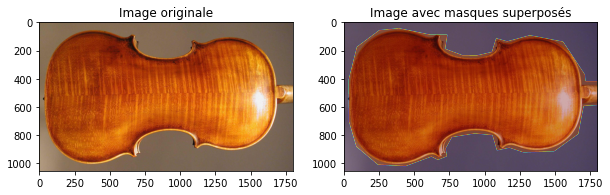

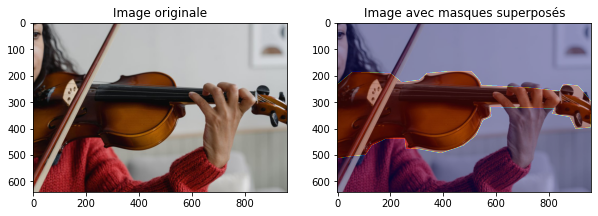

In [71]:
import matplotlib.pyplot as plt


# Créez une instance de votre dataset et chargez les données
dataset = ViolinDataset()
dataset.load_violins("./train", "./train/via_project_3Nov2024_17h58m_json.json")
dataset.prepare()

# Parcourez quelques images pour tester
for image_id in range(min(2, len(dataset.image_info))):  # Affiche les 5 premières images
    # Charger l'image et le masque
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Afficher l'image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image originale")
    
    # Superposer le masque sur l'image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for i in range(mask.shape[-1]):
        plt.imshow(mask[:, :, i], alpha=0.3, cmap="jet")  # Affiche chaque masque avec une transparence

    plt.title("Image avec masques superposés")
    plt.show()


In [72]:
# Training dataset
dataset_train = ViolinDataset()
dataset_train.load_violins('./train', './train/via_project_10Nov2024_21h9m_json.json')
dataset_train.prepare()

# Validation dataset
dataset_val = ViolinDataset()
dataset_val.load_violins('./test', './test/via_project_10Nov2024_16h47m_json.json')
dataset_val.prepare()

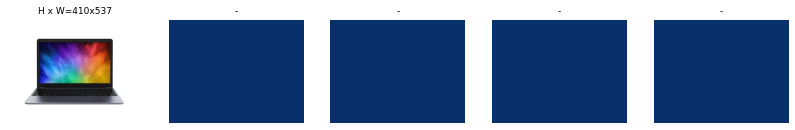

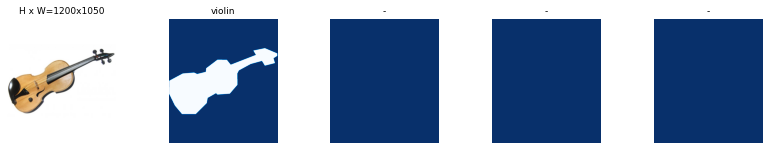

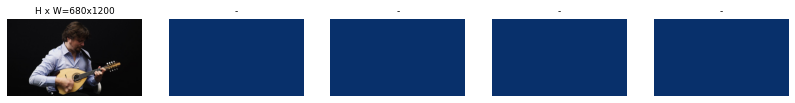

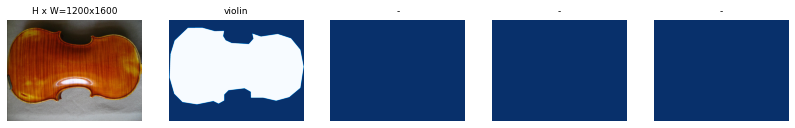

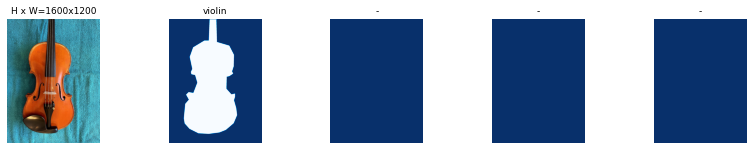

In [73]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)  # Assuming this returns class_ids along with the mask
    print(dataset_train)
    
    # Pass the mask and corresponding class_ids to visualize.display_top_masks
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Create Model

In [74]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [75]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [76]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/tani/Documents/git/mrcnn/logs/violin20241111T0830/mask_rcnn_violin_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/engine/training_generator.py:47

Epoch 1/20
 6/23 [======>.......................] - ETA: 10:48 - loss: 3.5128 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2428 - mrcnn_class_loss: 0.5444 - mrcnn_bbox_loss: 0.9691 - mrcnn_mask_loss: 1.7527

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

 8/23 [=========>....................] - ETA: 9:12 - loss: 3.1310 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.4449 - mrcnn_bbox_loss: 0.8971 - mrcnn_mask_loss: 1.5489

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

 9/23 [==========>...................] - ETA: 8:25 - loss: 2.9680 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2325 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.8663 - mrcnn_mask_loss: 1.4567

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

11/23 [============>.................] - ETA: 7:10 - loss: 2.6682 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.7930 - mrcnn_mask_loss: 1.2997

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

13/23 [===============>..............] - ETA: 5:55 - loss: 2.4246 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.7258 - mrcnn_mask_loss: 1.1750

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

21/23 [=========================>....] - ETA: 1:24 - loss: 1.8843 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.5835 - mrcnn_mask_loss: 0.8904

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

22/23 [==========================>...] - ETA: 52s - loss: 1.8426 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.5735 - mrcnn_mask_loss: 0.8660 

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

23/23 [============================>.] - ETA: 20s - loss: 1.7989 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.5613 - mrcnn_mask_loss: 0.8430

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

24/23 [==============================] - 908s 38s/step - loss: 1.7555 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.1881 - mrcnn_bbox_loss: 0.5483 - mrcnn_mask_loss: 0.8221 - val_loss: 1.1023 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.3056 - val_mrcnn_class_loss: 0.0378 - val_mrcnn_bbox_loss: 0.4328 - val_mrcnn_mask_loss: 0.3211
Epoch 2/20
 6/23 [======>.......................] - ETA: 9:00 - loss: 0.6143 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.3014

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

11/23 [============>.................] - ETA: 6:22 - loss: 0.5937 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.2841

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

13/23 [===============>..............] - ETA: 5:22 - loss: 0.5627 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2754

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

14/23 [================>.............] - ETA: 4:53 - loss: 0.5833 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2726

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

22/23 [==========================>...] - ETA: 49s - loss: 0.5838 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.1824 - mrcnn_mask_loss: 0.2554 

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

24/23 [==============================] - 853s 36s/step - loss: 0.5647 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.2496 - val_loss: 2.0501 - val_rpn_class_loss: 0.0186 - val_rpn_bbox_loss: 1.3196 - val_mrcnn_class_loss: 0.0394 - val_mrcnn_bbox_loss: 0.3572 - val_mrcnn_mask_loss: 0.3154
Epoch 3/20
 3/23 [==>...........................] - ETA: 10:57 - loss: 0.2982 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1638

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

 6/23 [======>.......................] - ETA: 9:14 - loss: 0.4460 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1708

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

13/23 [===============>..............] - ETA: 5:34 - loss: 0.6135 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2023

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

20/23 [========================>.....] - ETA: 1:52 - loss: 0.5622 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1796 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2007

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

22/23 [==========================>...] - ETA: 50s - loss: 0.5418 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1982 

ERROR:root:Error processing image {'id': '185.jpg', 'source': 'violin', 'path': './train/185.jpg', 'size': 85212, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/a

24/23 [==============================] - 879s 37s/step - loss: 0.5706 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.2041 - val_loss: 2.7660 - val_rpn_class_loss: 0.0142 - val_rpn_bbox_loss: 2.0264 - val_mrcnn_class_loss: 0.0618 - val_mrcnn_bbox_loss: 0.3715 - val_mrcnn_mask_loss: 0.2923
Epoch 4/20
24/23 [==============================] - 857s 36s/step - loss: 0.5080 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.1880 - val_loss: 1.5442 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.8236 - val_mrcnn_class_loss: 0.0678 - val_mrcnn_bbox_loss: 0.3052 - val_mrcnn_mask_loss: 0.3402
Epoch 5/20
24/23 [==============================] - 855s 36s/step - loss: 0.4788 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1840 - val_loss: 2.1411 - val_rpn_class_loss: 0.0256 - 

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

 8/23 [=========>....................] - ETA: 7:53 - loss: 0.4701 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1622

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

 9/23 [==========>...................] - ETA: 7:25 - loss: 0.4458 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1576

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

11/23 [============>.................] - ETA: 6:27 - loss: 0.4155 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1522

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

13/23 [===============>..............] - ETA: 5:18 - loss: 0.3899 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1473

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

21/23 [=========================>....] - ETA: 1:16 - loss: 0.4030 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1473

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

22/23 [==========================>...] - ETA: 47s - loss: 0.3975 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.1458 

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

23/23 [============================>.] - ETA: 18s - loss: 0.3980 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1448

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

24/23 [==============================] - 841s 35s/step - loss: 0.4011 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1464 - val_loss: 1.7987 - val_rpn_class_loss: 0.0148 - val_rpn_bbox_loss: 1.1419 - val_mrcnn_class_loss: 0.0873 - val_mrcnn_bbox_loss: 0.2703 - val_mrcnn_mask_loss: 0.2844
Epoch 8/20
 6/23 [======>.......................] - ETA: 8:22 - loss: 0.2855 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1230

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

11/23 [============>.................] - ETA: 6:10 - loss: 0.3086 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1288

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

13/23 [===============>..............] - ETA: 5:12 - loss: 0.3224 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1321

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

14/23 [================>.............] - ETA: 4:44 - loss: 0.3327 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1358

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

22/23 [==========================>...] - ETA: 48s - loss: 0.3311 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1385 

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

24/23 [==============================] - 854s 36s/step - loss: 0.3288 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1381 - val_loss: 2.4207 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 1.7799 - val_mrcnn_class_loss: 0.0747 - val_mrcnn_bbox_loss: 0.2716 - val_mrcnn_mask_loss: 0.2695
Epoch 9/20
 3/23 [==>...........................] - ETA: 8:14 - loss: 0.2446 - rpn_class_loss: 9.9031e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1088

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

 6/23 [======>.......................] - ETA: 8:02 - loss: 0.3622 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1559  

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

13/23 [===============>..............] - ETA: 5:01 - loss: 0.4325 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1845

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

20/23 [========================>.....] - ETA: 1:45 - loss: 0.3841 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1702

ERROR:root:Error processing image {'id': '189.jpg', 'source': 'violin', 'path': './train/189.jpg', 'size': 181944, 'polygons': []}
Traceback (most recent call last):
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/model.py", line 1218, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/mrcnn/utils.py", line 368, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/tani/anaconda3/envs/mrcnn/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 209, in call_plugin
    return func(*args, **kwargs)
  File "/home/tani/

24/23 [==============================] - 841s 35s/step - loss: 0.3976 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1707 - val_loss: 1.6258 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.9903 - val_mrcnn_class_loss: 0.0907 - val_mrcnn_bbox_loss: 0.2856 - val_mrcnn_mask_loss: 0.2493
Epoch 10/20
24/23 [==============================] - 862s 36s/step - loss: 0.3551 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1384 - val_loss: 1.2134 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.6792 - val_mrcnn_class_loss: 0.0649 - val_mrcnn_bbox_loss: 0.2646 - val_mrcnn_mask_loss: 0.1956
Epoch 11/20
24/23 [==============================] - 843s 35s/step - loss: 0.3161 - rpn_class_loss: 8.4270e-04 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1360 - val_loss: 3.2125 - val_rpn_class_loss: 0.0

In [77]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#model.train(dataset_train, dataset_val, 
 #           learning_rate=config.LEARNING_RATE / 10,
  #          epochs=5, 
   #         layers="all")

In [78]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [88]:
class InferenceConfig(ViolinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = './logs/violin20241111T0830/mask_rcnn_violin_0020.h5'


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/violin20241111T0830/mask_rcnn_violin_0020.h5
Re-starting from epoch 20


In [122]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
image_id = dataset_val.image_ids[38]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

IndexError: index 38 is out of bounds for axis 0 with size 38

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


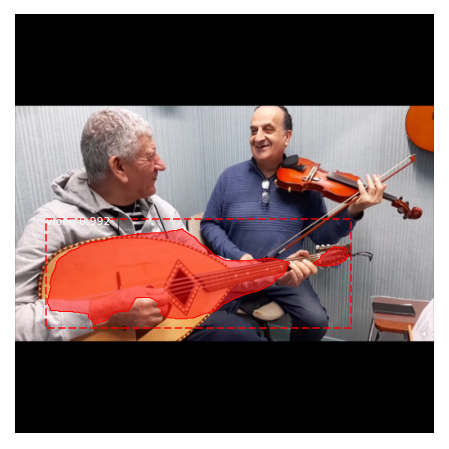

In [98]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


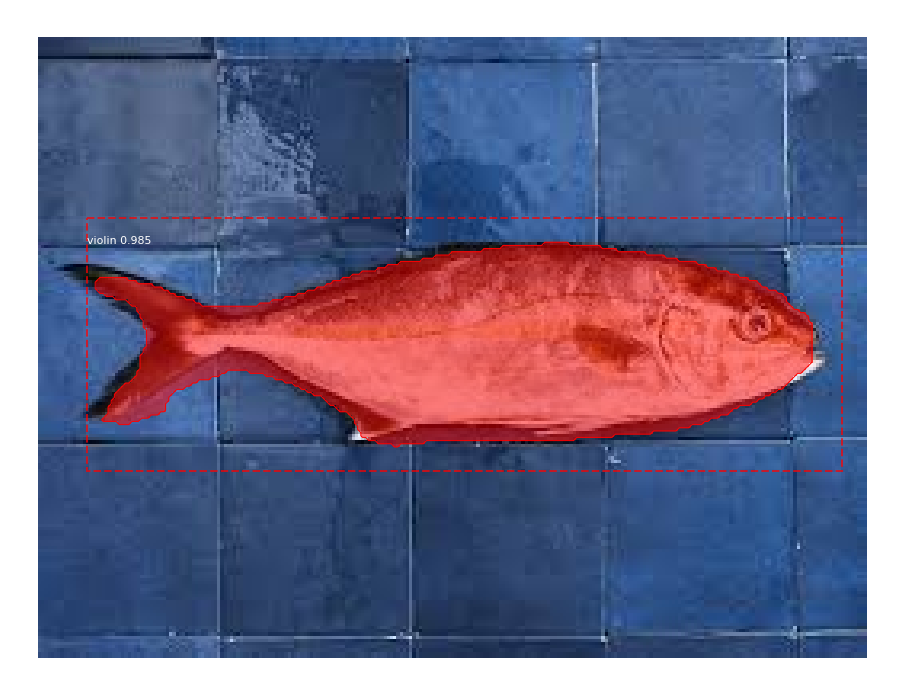

In [ ]:
# Charger votre image
image_path = "./18.avif"  # Remplacez par le chemin de votre image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Effectuer la détection
results = model.detect([image], verbose=1)
r = results[0]

# Visualiser les résultats
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["Background", "violin"], r['scores'])

## Evaluation

In [83]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on all validation images
image_ids = dataset_val.image_ids
APs = []

for image_id in image_ids[0:]:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    
    # Skip images without ground truth objects (e.g., no violins)
    if len(gt_class_id) == 0:
        continue  # Skip this image and move to the next one

    # Preprocess the image for the model
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    print(image_id)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = \
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    
    APs.append(AP)

# Compute the mean Average Precision (mAP)
if len(APs) > 0:
    mean_AP = np.mean(APs)
    print("mAP: ", mean_AP)
else:
    print("No valid images with ground truth objects to calculate mAP.")


1
2
3
4
5
6
7
8


ValueError: cannot reshape array of size 0 into shape (0)